In [1052]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from PIL import Image
sns.set(rc={'axes.facecolor':'gray', 'figure.facecolor':'gray'})

In [902]:
data = pd.read_csv('disthistogram', header=0 , delimiter='\t', names=['Harmonic','Arithmetic','Geometric','VeinOrder','NN VeinOrder','v2x','v2y','vx','vy','v2width','vwidth'])
ven = pd.read_csv('venconnections', delimiter='\t')
ven2 = pd.read_csv('ven2connections', delimiter='\t')
im = Image.open('conprofile.png','r')
im2 = Image.open('covgrad.png','r')

x = data.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
data = pd.DataFrame(x_scaled, columns=data.columns)

ven.head()
ven.iloc[:,4].std()
data.iloc[0][5:9:2]
data.iloc[0][6:9:2]

In [903]:
cols = list(data.columns[1:7])
cols += list(data.columns[9:])
countdf = data.groupby(['vx','vy']).agg('count').drop(cols,axis=1).rename(columns={'Harmonic':'count'})
#countdf.head(5)
#countdf.index

In [904]:
copycountdf = countdf.copy()
#copycountdf['vx','vy'] = copycountdf.index
copycountdf.reset_index(level=0, inplace=True)
copycountdf.reset_index(level=0, inplace=True)

In [905]:
#copycountdf.head(5)

In [906]:
cdata = data.copy()
data = pd.merge(cdata,copycountdf,on=['vx','vy'])

In [907]:
cven2 = ven2.copy()
cven2.rename(columns={'startx':'v2x','starty':'v2y'},inplace=True)
cven2 = cven2.groupby(by=['v2x','v2y']).agg('max').drop(['endx','endy'],axis=1)
cven2.reset_index(level=0,inplace=True)
cven2.reset_index(level=0,inplace=True)

In [908]:
cvenend = ven.copy()
cvenend.rename(columns={'endx':'vx','endy':'vy','disttoroot':'disttorootp'},inplace=True)
cvenend = cvenend.groupby(by=['vx','vy']).agg('max').drop(['startx','starty'],axis=1)
cvenend.reset_index(level=0,inplace=True)
cvenend.reset_index(level=0,inplace=True)

In [909]:
cven = ven.copy()
cven.rename(columns={'startx':'vx','starty':'vy','disttoroot':'disttorootp'},inplace=True)
cven = cven.groupby(by=['vx','vy']).agg('max').drop(['endx','endy'],axis=1)
cven.reset_index(level=0,inplace=True)
cven.reset_index(level=0,inplace=True)

In [910]:
cven = pd.concat([cven,cvenend])

In [911]:
data = pd.merge(data,cven2,on=['v2x','v2y'])
data['seglength'] = np.sqrt(np.square(data['v2x']-data['vx'])+np.square(data['v2y']-data['vy']))
#data = pd.merge(data,cven,on=['vx','vy'],how='left')

In [912]:
cvendata = cven.groupby(by=['vx','vy']).agg('max')
cvendata.reset_index(level=0,inplace=True)
cvendata.reset_index(level=0,inplace=True)
cvendata =  pd.merge(data,cvendata,on=['vx','vy'],how='right')

In [913]:
attr = ['disttorootp','vx','vy']

In [914]:
Xtrain = np.array(cvendata[attr][pd.notna(cvendata['count'])]).reshape(-1,len(attr))
Xtest = np.array(cvendata[attr][pd.isna(cvendata['count'])]).reshape(-1,len(attr))
ytrain = np.array(cvendata[['count']][pd.notna(cvendata['count'])]).reshape(-1,1)
ytest = np.array(cvendata[['count']][pd.isna(cvendata['count'])]).reshape(-1,1)

In [915]:
tree = DecisionTreeClassifier(max_depth=3)
tree = tree.fit(Xtrain,ytrain)
cvendata['count'][pd.isna(cvendata['count']) ] = tree.predict(Xtest)

In [916]:
Xtrain = np.array(cvendata[attr][pd.notna(cvendata['vwidth'])]).reshape(-1,len(attr))
Xtest = np.array(cvendata[attr][pd.isna(cvendata['vwidth'])]).reshape(-1,len(attr))
ytrain = np.array(cvendata['vwidth'][pd.notna(cvendata['vwidth'])]).reshape(-1,1)
ytest = np.array(cvendata['vwidth'][pd.isna(cvendata['vwidth'])]).reshape(-1,1)

In [917]:
tree = DecisionTreeRegressor(max_depth=3)
tree = tree.fit(Xtrain,ytrain)
cvendata['vwidth'][pd.isna(cvendata['vwidth']) ] = tree.predict(Xtest)

In [1061]:
ven2std = ven2.iloc[:,4].std()
ven2max = ven2.iloc[:,4].max()
ven2min = ven2.iloc[:,4].min()
venstd = ven.iloc[:,4].std()
venmax = ven.iloc[:,4].max()
venmin = ven.iloc[:,4].min()
#normcm = (ven2max - ven2['disttoroot'])/(ven2max-ven2min)

In [1056]:
disc = list(data['disttoroot'].quantile(np.linspace(0,1,4)))
data['dtrootclass']=0
for i in range(0,len(disc)-1):
    data['dtrootclass'].loc[(data['disttoroot']>disc[i]) &  (data['disttoroot']<disc[i+1])] = float(i)+1.0

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Gerando um grafo a partir dos nodos das venações. Preciso encontrar uma representação que explique os dados que encontrei no outro notebook (picos que aparecem na derivada temporal da cobertura). Figura mostrada abaixo.

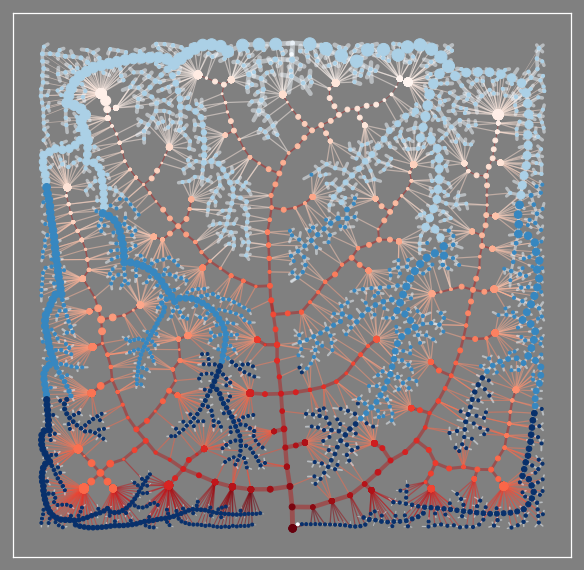

In [1070]:
# @hidden_cell
cmapseg = plt.cm.get_cmap('Reds')
rgba = cmapseg(np.square(data['disttoroot'])/(np.square(data['disttoroot']).max()-np.square(data['disttoroot']).min()))
fig = plt.figure(figsize=(10,10))
for i in range(data.shape[0]):
    plt.plot(data.iloc[i][5:9:2],data.iloc[i][6:9:2],'-',color=rgba[i],linewidth=np.power((data['seglength'].max()-data.iloc[i]['seglength'])/(data['seglength'].std()),0.3)-0.5,alpha=0.5,zorder=1)
for i in range(ven.shape[0]):
    plt.plot(ven.iloc[i][0:4:2],ven.iloc[i][1:4:2],'-',c='firebrick',markersize=1,linewidth=(venmax-ven.iloc[i][4])/venstd+0.5,alpha=0.5,zorder=1)
for i in range(ven2.shape[0]):
    plt.plot(ven2.iloc[i][0:4:2],ven2.iloc[i][1:4:2],'-',c='aliceblue',linewidth=(ven2max - ven2.iloc[i][4])/ven2std + 0.5,alpha=0.5,zorder=1)

plt.scatter(data['v2x'],data['v2y'],s=np.power(10*np.array(data['v2width'])+3,1.79),c=data['dtrootclass'], cmap=plt.get_cmap('Blues'),zorder=2)
plt.scatter(cvendata['vx'],cvendata['vy'],s=cvendata['count']+np.power(2*np.array(cvendata['vwidth']),2.82),c=(cvendata['disttorootp'].max()-cvendata['disttorootp'])/cvendata['disttorootp'].std(), cmap=plt.get_cmap('Reds'),zorder=2)
plt.xticks([])
plt.yticks([])
plt.show()

A rede apresentada acima facilita a compreensão do comportamento observado na figura abaixo, com 3 picos para cada uma das curvas. Cada pico representa um "burst" de cobertura de corante, ou seja, representa um aumento significativo na taxa cobertura de corante. Cada burst está associado a regiões da árvore complementar que tem graus de facilidade distintos em transportar o corante para a saída. Os nodos da rede complementar acima estão representados em 3 tons de azul distintos e cada um pode ser associado a um pico abaixo. A região em azul claro é a primeira a receber uma quantidade significativa de corante ao ponto aumentar a concentração da região. Isso pode ser conferido no perfil de concentração obtido a partir da simulação de CFD mostrado ainda mais abaixo. Observe que as regiões mais claras na outra figura, onde o corante já está mais presente, correspondem as regiões mais claras do grafo. O primeiro pico significa que quando o corante atinge essa região há um aumento da concentração nos canais complementares da região, que transportam o corante para a saída mais rapidamente. Esses canais complementares acabam servindo como fonte para mais difusão ocorrer.

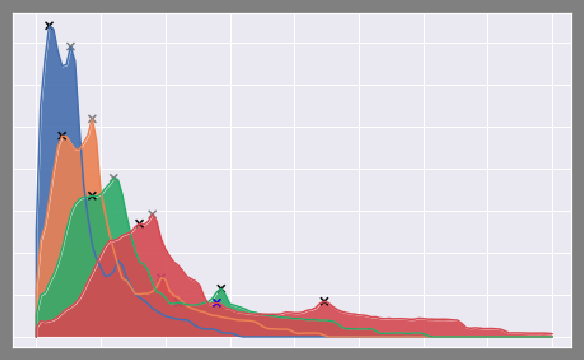

In [1054]:
fig = plt.figure(figsize=(10,7))
plt.imshow(np.asarray(im2))
plt.xticks([])
plt.yticks([])
plt.show()

O grafo acima precisa de alguma forma representar o que vemos abaixo, o resultado da simulação.

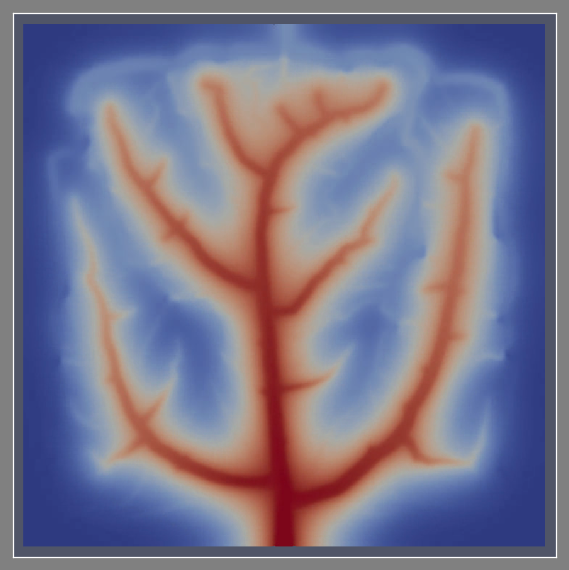

In [1055]:
fig = plt.figure(figsize=(10,10))
plt.imshow(np.asarray(im))
plt.xticks([])
plt.yticks([])
plt.show()

Os picos que vemos abaixo são "bursts" no qual há um aumento grande na cobertura do corante. Provavelmente tem a ver com os nodos mais importantes da venação.

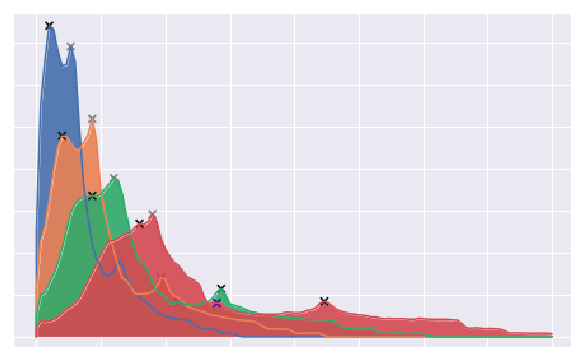

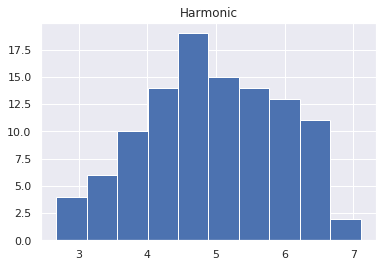

In [14]:
data.groupby(['VeinOrder','NN VeinOrder']).get_group((2,3)).drop(['VeinOrder','Geometric','Arithmetic','NN VeinOrder'],axis=1).hist(bins=10)
#plt.xlim(1,6)
plt.show()
#data['NN VeinOrder'].hist(bins=10)
#plt.xlim(1,5)
#plt.show()

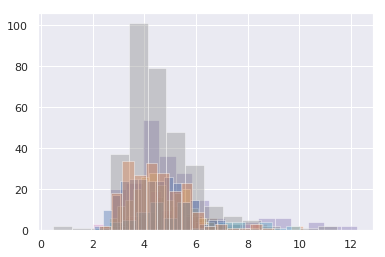

In [19]:
for i in range(1,5):
    for j in range(1,4):
        df = data.groupby(['VeinOrder','NN VeinOrder']).get_group((i,j)).drop(['VeinOrder','Geometric','Arithmetic','NN VeinOrder'],axis=1)
        sns.distplot(df, bins=15,hist=True, kde=False, rug=False)

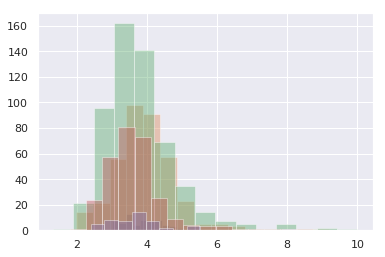

In [100]:
for i in range(1,6):
    df = data.groupby('VeinOrder').get_group(i).drop(['VeinOrder','Geometric','Arithmetic','NN VeinOrder'],axis=1)
    sns.distplot(df, bins=15,hist=True, kde=False, rug=False)



In [53]:
data.describe()

,Harmonic,Arithmetic,Geometric,VeinOrder,NN VeinOrder
count,1339.000000,1339.000000,1339.000000,1339.000000,1339.00000
mean,3.814889,4.091761,3.949626,2.908887,2.45183
std,0.950355,0.956059,0.949267,0.920163,0.77693
min,1.324530,1.804050,1.637970,1.000000,1.00000
25%,3.195470,3.515505,3.372795,2.000000,2.00000
50%,3.683680,3.983070,3.827150,3.000000,2.00000
75%,4.198680,4.506980,4.352100,3.500000,3.00000
max,9.997340,9.997340,9.997340,6.000000,4.00000


In [49]:
data.head()

,Harmonic,Arithmetic,Geometric,VeinOrder,NN VeinOrder
0,4.67798,4.72853,4.70258,2,2
1,4.64436,4.64436,4.64436,1,3
2,2.68025,3.43605,3.09173,2,2
3,4.92177,4.94629,4.93402,1,3
4,3.91793,4.11680,4.01123,3,2


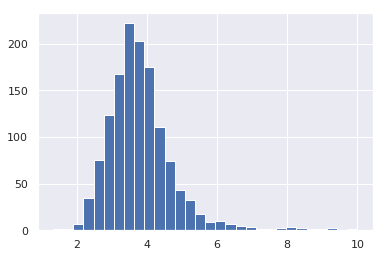

In [91]:
data['Harmonic'].hist(bins=30)
plt.show()


In [22]:
data.mean()

Distances Histogram    3.814889
dtype: float64

In [23]:
data.describe()

,Distances Histogram
count,1339.000000
mean,3.814889
std,0.950355
min,1.324530
25%,3.195470
50%,3.683680
75%,4.198680
max,9.997340


In [24]:
data.median()

Distances Histogram    3.68368
dtype: float64

In [28]:
data.kurtosis()

Distances Histogram    6.198549
dtype: float64

In [29]:
data.skew()

Distances Histogram    1.737346
dtype: float64